In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import plotting
plt.style.use(plotting.blueprint)
from IPython.display import display
from ipywidgets import interact
import scipy.spatial
import pandas as pd

/home/daniel/.virtualenvs/IGRlaptop21/teaching-stats/local/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Gaussian processes

In the Wiener process introduced in the previous section the size of a random step is determined only by the length of time which the step takes.

What if we want to make a more complicated requirement on the data, so that the next step is determined by all of the previous steps? 

When we do this we get a Gaussian process, and the way in which steps must relate to the previous steps are determined by *covariance functions*.

## Covariance functions

In [2]:
class CovarianceFunction(object):
    """
    The base class for a covariance function.
    """
    def __init__(self, active_dimensions = "*", **kwargs):
        if not active_dimensions == "*":
            self.active_dimensions = active_dimensions
        else: 
            self.active_dimensions = None
            
        self.args = kwargs
            
    def distance(self, x, y):
        """
        Calculate the square euclidean distance between points in the active dimensions.
        """
        if self.active_dimensions:
            x = np.atleast_2d(x[self.active_dimensions])
            y = np.atleast_2d(y[self.active_dimensions])
        else:
            x = np.atleast_2d(x)
            y = np.atleast_2d(y)
            
        distances = scipy.spatial.distance.cdist(x, y, "sqeuclidean")
        
        return distances
    
    def __call__(self, x, y, **args):
        return self._evaluate(x, y, **args)
    
    def __mul__(self, covariance_function):
        if hasattr(covariance_function, "product") and covariance_function.compound:
            return covariance_function * self
        else:
            new_cv = ProductCovariance()
            new_cv = new_cv * self
            new_cv = new_cv * covariance_function
            return new_cv
        
    def __add__(self, covariance_function):
        if hasattr(covariance_function, "sum") and covariance_function.compound:
            return covariance_function + self
        else:
            new_cv = SumCovariance()
            new_cv = new_cv + self
            new_cv = new_cv + covariance_function
            return new_cv

In [3]:
class ExponentialQuadratic(CovarianceFunction):
    def __init__(self, length=1, **parameters):
        super().__init__(**parameters)
        self.args['length'] = length
    
    def _evaluate(self, x, y, length = None):
        if not length:
            length = self.args['length']
        return np.exp(-0.5 * 1./length * self.distance(x, y))

In [4]:
class Periodic(CovarianceFunction):
    def __init__(self, length=1, period=np.pi, **parameters):
        super().__init__(**parameters)
        self.args['length'] = length
        self.args['period'] = period
    
    def _evaluate(self, x, y, length = None, period=None):
        if not length:
            length = self.args['length']
        if not period:
            period = self.args['period']
        return np.exp(- (2*np.sin(np.pi*np.sqrt(self.distance(x,y)/ length**2)/period)**2) )

In [5]:
class ProductCovariance(CovarianceFunction):
    
    product = True
    
    def __init__(self):
        self.covariance_functions = []
        pass
    
    def __mul__(self, covariance_function):
        self.covariance_functions.append(covariance_function)
        return self
        
    def _evaluate(self, x, y, **args):
        return(np.prod([cv(x, y) for cv in self.covariance_functions], axis=0))

In [6]:
class SumCovariance(CovarianceFunction):
    
    sum = True
    
    def __init__(self):
        self.covariance_functions = []
        pass
    
    def __add__(self, covariance_function):
        self.covariance_functions.append(covariance_function)
        return self
        
    def _evaluate(self, x, y, **args):
        return(np.sum([cv(x, y) for cv in self.covariance_functions], axis=0))

In [7]:
def exp(x, y, length=1):
    """The exponential covariance function"""
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)
    distances = scipy.spatial.distance.cdist(x, y, "euclidean")
    return np.exp(1./length * (distances))

In [8]:
def localperiodic(x, y, length1=1, length2=1, period=1):
    """The locally-periodic covariance function"""
    return(exp_q(x,y, length1) * periodic(x, y, length2, period))

## The Gaussian process

In [252]:
class GaussianProcess(object):
    """
    A simple implementation of a Gaussian process.
    """
    
    def __init__(self, covariance, **parameters):
        """
        Parameters
        ----------
        covariance : function
            The covariance function to use for the GP.
        """
        self.covariance_function = covariance#(**parameters)
        self.covariance_parameters = parameters

        self.x_columns = ["x"]
        self.y_columns = ["y"]
        self.y_error_columns = [col+"_err" for col in self.y_columns]
        self.data = pd.DataFrame(columns=["x", "y"])
        
    def __call__(self, x, samples=0, batch_size=None, **kwargs):
        """
        Evaluate the Gaussian process, and return the mean 
        and variance, and potentially some samples.
        
        Parameters
        ----------
        x : np.array
            The locations at which the GP should be evaluated.
        samples : int, optional
            The number of samples to draw from the GP
            Defaults to 0, in which case no samples are returned.
            
        Returns
        -------
        mean : ndarray
            The mean of the Gaussian processes.
        var : ndarray
            The variance of the Gaussian processes.
        """
        mean, var = self.evaluate(x, batch_size)
        if samples > 0:
            samples = self.samples(x, realisations=samples, **kwargs)
            return mean, var, samples
        else:
            return mean, var
        
    def _invert(self, matrix):
        """
        Perform a matrix inversion.
        
        Parameters
        ----------
        matrix : ndarray
            The matrix which should be inverted.
            
        Returns
        -------
        inverse : ndarray
            The inverted matrix.
        """
        return np.linalg.inv(matrix)
        
    def _compute(self, x):
        """
        Compute the covariance matrices.
        
        Parameters
        ----------
        x : np.array
            The locations at which the GP should be evaluated.
        """
        x = np.atleast_2d(x)
        
        # Check if there is any conditioning data. If there is, calculate the appropriate matrices.
        if len(self.data)>0:
            x_data = np.atleast_2d(self.data[self.x_columns])
            
            self.Kdata = self.covariance_function(x_data, x_data, **self.covariance_parameters)
            if self.y_error_columns[0] in self.data.columns:
                self.error_matrix = np.identity(len(x_data)) * np.array(self.data[self.y_error_columns]**2)
            
                self.Kdata_inv = self._invert(self.Kdata + self.error_matrix)
            else:
                self.Kdata_inv = self._invert(self.Kdata)
                
            self.Kdata_new = self.covariance_function(x_data, x, **self.covariance_parameters)
        else:
            self.Kdata_inv = np.array([])
            self.Kdata_new = np.array([])
        self.Knew_new = self.covariance_function(x, x, **self.covariance_parameters)
        
    def _data(self, data, x_columns, y_columns):
        
        self.x_columns = x_columns
        self.y_columns = y_columns
        self.data = data
        
    def evaluate(self, x, batch_size=None):
        """
        Evaluate the Gaussian process.
        
        Parameters
        ----------
        x : np.array
            The locations at which the GP should be evaluated.
            
        See also
        ---------
        self.__call__
        """
        means = {}
        var = {}
        if batch_size:
            ix0 = np.array(x).shape[0]
            x_rows = np.array(x[:ix0-(ix0%batch_size)]).reshape(int(np.floor(ix0/batch_size)), batch_size, len(self.x_columns))
            #if ix0 > 0:
            #    x_rows = np.append(x_rows, np.array(x)[-ix0:])
            for i, row in enumerate(x_rows):
                batch_mean, batch_vars = self.evaluate(row)
                if i == 0:
                    for key, vals in batch_mean.items():
                        means[key] = vals
                    for key, vals in batch_vars.items():
                        var[key] = vals
                else:
                    for key, vals in batch_mean.items():
                        means[key] = np.append(means[key], vals)
                    for key, vals in batch_vars.items():
                        var[key] = np.append(var[key], vals)
            return means, var
        
        self._compute(x)

        for y_column in self.y_columns:
            if len(self.Kdata_new) == 0:
                means[y_column] = np.zeros(x.shape[0])
            else:
                means[y_column] = np.dot(np.dot(self.Kdata_new.T, self.Kdata_inv), self.data[y_column])
            if len(self.Kdata_new) == 0:
                var[y_column] = self.Knew_new
            else:        
                var[y_column] = self.Knew_new - np.dot(np.dot(self.Kdata_new.T, self.Kdata_inv), self.Kdata_new)
            
        return means, var
    
    def samples(self, x, realisations = 10, continuous=False, alpha=0.1, mstep=5, tstep=0.1):
        
        means, var = self.evaluate(x)
        
        p = []
        z = []
        
        samples = {}
        for y_column in self.y_columns:
            
            if continuous:
                steps = realisations
                for step in range(steps):
                    if step == 0:
                        initial = np.random.multivariate_normal(mean = means[y_column], cov=var[y_column])
                        z.append(initial)
                        p.append(initial)
                    if step % mstep == 0:
                        new_state = alpha*p[-1] + (np.sqrt(1-alpha**2) * np.random.multivariate_normal(mean = means[y_column], cov=var[y_column]))
                        z.append(z[-1])
                        p.append(new_state)
                    else:
                        a = z[-1]
                        b = p[-1] 
                        c = -1 * z[-1]
                        d = p[-1]

                        z.append((a * np.sin(tstep)) + (b * np.cos(tstep)))
                        p.append((c * np.sin(tstep)) + (d * np.cos(tstep)))

                samples[y_column] = (means[y_column] + np.array(z))[1:,:].T
            else:
                samples[y_column] = np.random.multivariate_normal(mean = means[y_column], cov=var[y_column], size=realisations).T
            
        return samples
    
    def plot(self, x, realisations = 10, ax=None, continuous_samples=True, lw=2):
        if not ax:
            f, ax = plt.subplots(1,1, dpi=300)
        means, var = self.evaluate(x)
       
        ax.plot(x, self.samples(x, realisations, continuous=continuous_samples)[self.y_columns[0]], lw=lw)
        ax.plot(x, means[self.y_columns[0]], color='yellow', lw=lw+1)
        ax.plot(x, means[self.y_columns[0]] + np.diag(var[self.y_columns[0]]), color='yellow', lw=lw, linestyle="--")
        ax.plot(x, means[self.y_columns[0]] - np.diag(var[self.y_columns[0]]), color='yellow', lw=lw, linestyle="--")

In [253]:
points = pd.DataFrame({"x": np.linspace(-20, 20, 300) })

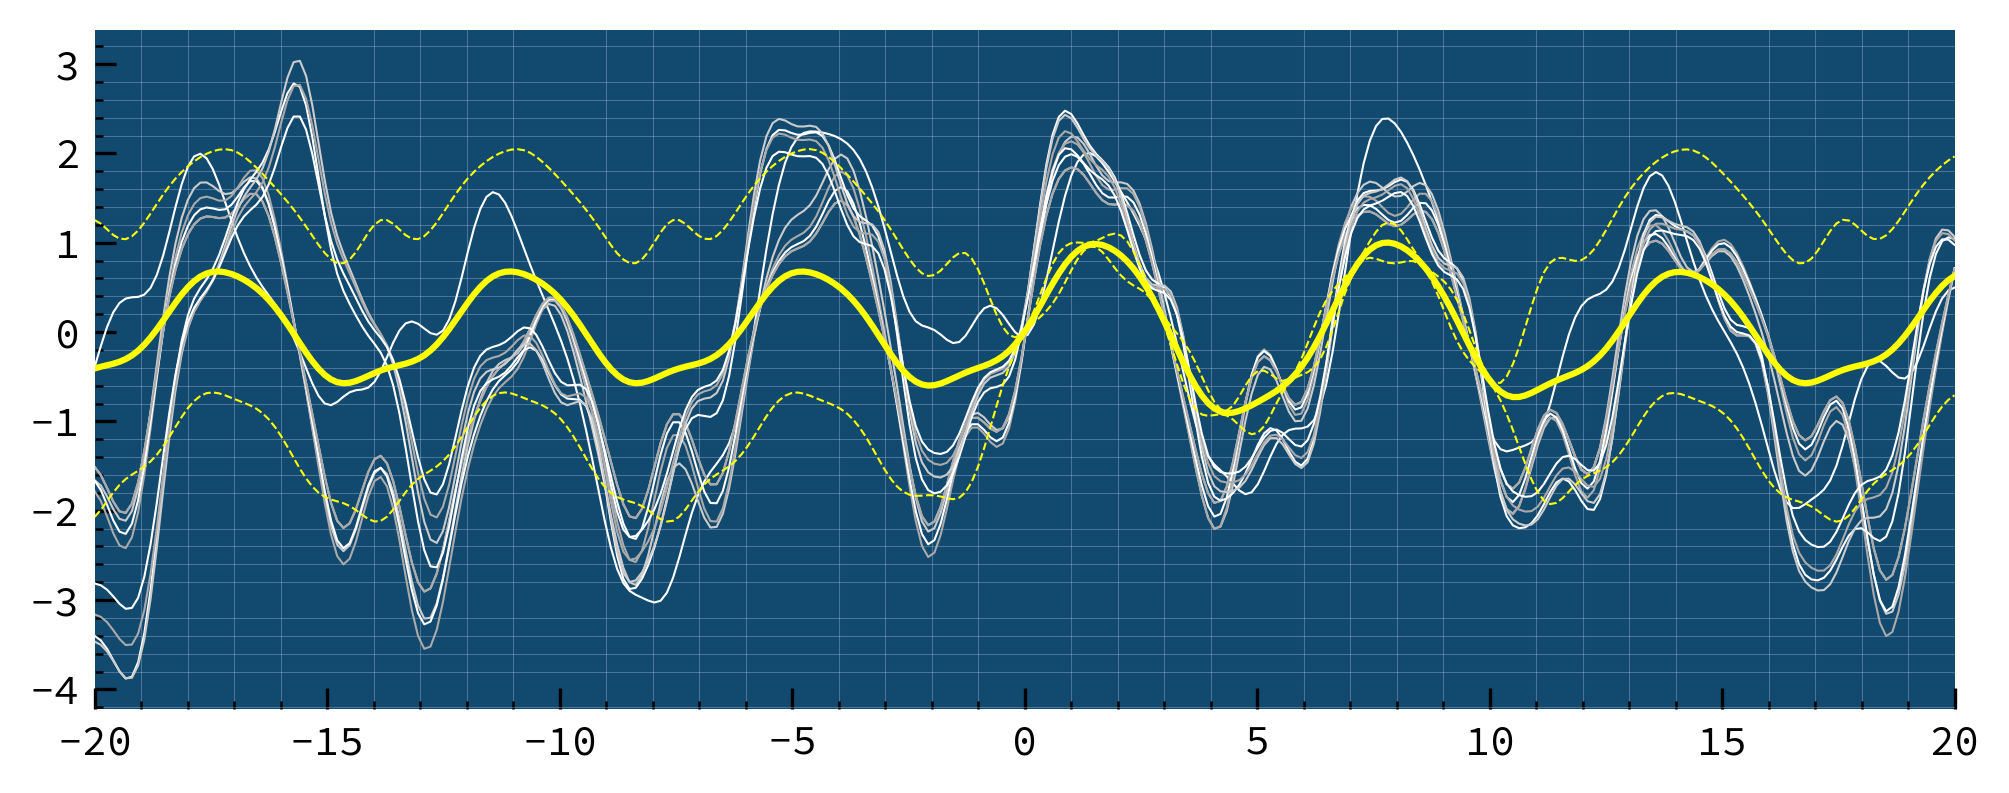

In [254]:
gp = GaussianProcess(ExponentialQuadratic(length=2) + Periodic(length=1, period=2*np.pi) * Periodic(length=1, period=2*np.pi),)

f, ax = plt.subplots(1,1, figsize=(8,3), dpi=300)


data = pd.DataFrame({"x": np.linspace(0, 10, 8),
                     "y": np.sin(np.linspace(0, 10, 8)),
                     "y_err": .15 * np.ones(8)
                    })
gp._data(data, ["x"], ["y"])

ax.grid(False)
#ax.set_xticks([])
#ax.set_yticks([])
ax.set_xlim([-20,20]);
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)

gp.plot(points, lw=0.5, continuous_samples=True, realisations=10, ax=ax)

In [255]:
hills = pd.read_json("../data/arrochar_shuttle.json")

In [275]:
gp = GaussianProcess(ExponentialQuadratic(length=1, active_dimensions=[0,1]))

In [276]:
gp._data(hills, ["latitude", "longitude"], ["elevation"])

In [277]:
lons_new = np.linspace(-4.9, -4.70, 150)
lats_new = np.linspace(56.20, 56.35, 150)
points_new = np.transpose([np.tile(lons_new, len(lats_new)), np.repeat(lats_new, len(lons_new))])
points_new = pd.DataFrame({"latitude": points_new[:,0], "longitude": points_new[:,1]})

In [278]:
mean, var = gp(points_new, batch_size=20)

ValueError: shapes (2,2) and (400,) not aligned: 2 (dim 1) != 400 (dim 0)

In [269]:
mean

{'elevation': array([ -7548.77734375,  -3467.23413086, -18083.68237305, ...,
         -3734.41503906,  -7184.68945312,   7868.28125   ])}

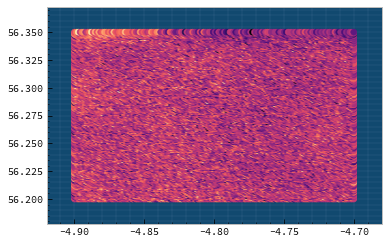

In [270]:
plt.scatter(points_new.latitude, points_new.longitude, c=mean['elevation'])

In [68]:
np.reshape?

In [82]:
np.array(points_new[['latitude', 'longitude']]).reshape(-1, 10, 2)[0]

array([[-4.9       , 56.2       ],
       [-4.89865772, 56.2       ],
       [-4.89731544, 56.2       ],
       [-4.89597315, 56.2       ],
       [-4.89463087, 56.2       ],
       [-4.89328859, 56.2       ],
       [-4.89194631, 56.2       ],
       [-4.89060403, 56.2       ],
       [-4.88926174, 56.2       ],
       [-4.88791946, 56.2       ]])